In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# You don't have to understand how this function works, since it uses Python features from beyond Data 8.
def first_digit(num):
    return int(str(num)[0])

## Example: Benford's Law

In [3]:
first_digit(32)

3

In [4]:
first_digit(17719087)

1

In [5]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)

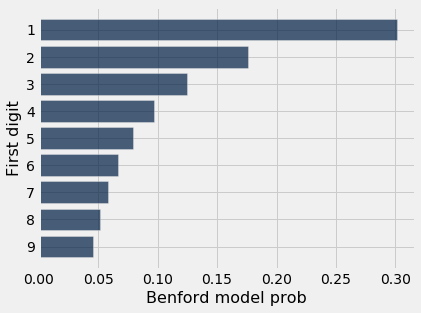

In [6]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford model prob', benford_model)
benford.barh('First digit')

In [7]:
# County populations from the census data
counties = Table.read_table('counties.csv')
counties = counties.where('SUMLEV', 50).select(5,6,9).relabeled(0,'State').relabeled(1,'County').relabeled(2,'Population')
counties.show(3)

State,County,Population
Alabama,Autauga County,54684
Alabama,Baldwin County,183216
Alabama,Barbour County,27336


In [8]:
first_digits = counties.apply(first_digit, 'Population')
counties = counties.with_column('First digit', first_digits)
counties.show(3)

State,County,Population,First digit
Alabama,Autauga County,54684,5
Alabama,Baldwin County,183216,1
Alabama,Barbour County,27336,2


In [9]:
num_counties = counties.num_rows

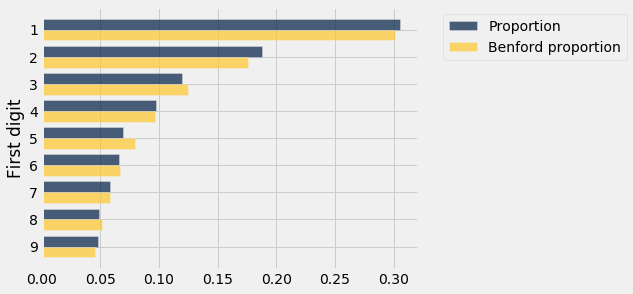

In [10]:
by_digit = counties.group('First digit')
proportions = by_digit.column('count')/num_counties
by_digit = by_digit.with_columns(
    'Proportion', proportions,
    'Benford proportion', benford_model
)
by_digit.drop('count').barh('First digit')

Null hypothesis: 

Alternative hypothesis: 

Test statistic: ___

Fill in the blank with "Bigger" or "Smaller":

___ values of the test statistic favor the alternative

In [11]:
observed_tvd = sum(abs(proportions - benford_model))/2
observed_tvd

0.019227569718005835

In [12]:
sample_proportions(num_counties, benford_model)

array([0.30140038, 0.18332272, 0.12603437, 0.09293444, 0.07511139,
       0.06556334, 0.05697008, 0.05092298, 0.04774029])

In [13]:
simulated_frequencies = sample_proportions(num_counties, benford_model)
tvd = sum(abs(simulated_frequencies - benford_model))/2
tvd

0.032411850850834645

In [14]:
def simulate_county_first_digits():
    simulated_frequencies = sample_proportions(num_counties, benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

In [15]:
simulated_tvds = make_array()

for i in np.arange(10000):
    simulated_tvds = np.append(simulated_tvds, simulate_county_first_digits())

Observed TVD:  0.019227569718005835


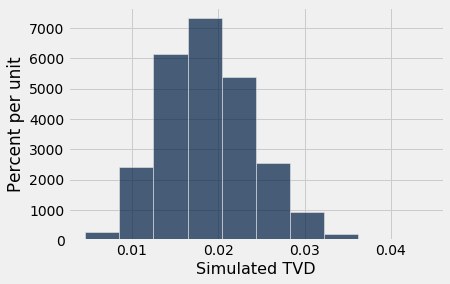

In [16]:
Table().with_column('Simulated TVD', simulated_tvds).hist(0)
print("Observed TVD: ", observed_tvd)

In [17]:
np.count_nonzero(simulated_tvds >= observed_tvd) / 10000

0.4447

Are the data consistent with the null hypothesis?

## Example: sleep survey

In [18]:
survey = Table.read_table('welcome_survey_v1.csv')
survey

Year,Extroversion,Number of textees,Hours of sleep,Handedness,Pant leg,Sleep position
First,6,3,3,Right-handed,Right leg in first,On your back
Second,4,1,3,Left-handed,I don't know,On your left side
Second,2,5,3,Left-handed,Right leg in first,On your left side
First,2,1,4,Right-handed,Right leg in first,On your left side
First,4,3,4,Left-handed,Right leg in first,On your left side
First,7,5,4,Right-handed,Right leg in first,On your right side
First,8,20,4,Right-handed,Left leg in first,On your stomach
First,2,8,4,Right-handed,Right leg in first,On your stomach
Fourth,6,3,4,Right-handed,Left leg in first,On your back
Fourth,4,3,4,Right-handed,I don't know,On your right side


In [19]:
def simplify(sleep_position):
    if sleep_position == 'On your left side' or sleep_position == 'On your right side':
        return 'side'
    else:
        return 'back or stomach'
    
survey = survey.with_column(
    'position',
    survey.apply(simplify, 'Sleep position')
).select('position', 'Hours of sleep')

survey

position,Hours of sleep
back or stomach,3
side,3
side,3
side,4
side,4
side,4
back or stomach,4
back or stomach,4
back or stomach,4
side,4


In [20]:
survey.group('position', np.average)

position,Hours of sleep average
back or stomach,7.2637
side,7.16424


Null hypothesis: 

Alternative hypothesis: 

Test statistic: ___

Fill in the blank with "Bigger" or "Smaller":

___ values of the test statistic favor the alternative

In [21]:
def compute_test_statistic(tbl):
    grouped = tbl.group('position', np.average)
    avgs = grouped.column('Hours of sleep average')
    return avgs.item(1) - avgs.item(0)

In [22]:
obs_test_stat = compute_test_statistic(survey)
obs_test_stat

-0.09946608619198205

In [23]:
random_labels = survey.sample(with_replacement=False).column('position')

In [24]:
def simulate_under_null():
    random_labels = survey.sample(with_replacement=False).column('position')
    relabeled_tbl = survey.with_column('position', random_labels)
    return compute_test_statistic(relabeled_tbl)

In [25]:
simulated_diffs = make_array()
for i in np.arange(1000):
    null_stat = simulate_under_null()
    simulated_diffs = np.append(simulated_diffs, null_stat)

Observed Difference:  -0.09946608619198205


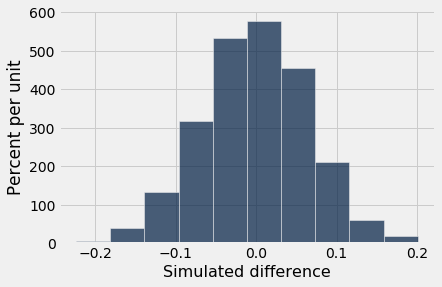

In [26]:
Table().with_column('Simulated difference', simulated_diffs).hist(0)
print("Observed Difference: ", obs_test_stat)

In [27]:
np.mean(simulated_diffs <= obs_test_stat)

0.071

Are the data consistent with the null hypothesis?